# Построение модели определения стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

***Описание проекта***

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Перед нами стояла задача- построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

Мы использовали технологию градиетного бустинга в моделях CatBoostRegressor и LightGBM, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor

По итогам качества и скорости обучения на тестовых данных - с небольшим отрывом от CatBoostRegressor побеждает модель LightGBM, но сильно уступает по скорости предсказания.

Таким образом для компании "Не бит, не крашен" можем смело рекомендовать модель CatBoostRegressor, т.к. можно немного поступиться со скоростью обучения в пользу достижения скорости работы на новых данных при сохранении приблизительно тех же показателей по качеству предсказания

Описание данных
Данные находятся в файле /datasets/autos.csv. Скачать датасет. 

Признаки
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
 
  Целевой признак
 - Price — цена (евро)
 
 
***Этапы работы***
В данном прокте будет решать задаса регрессии- определении цены автомобиля на основании известных параментров.

Основные этапы работы будут такие:
1. Анализ данных на анамалии   и предобработка - работа с пропусками и дубликатами.
2. Кодированные разными способами под разные виды ML
3. Масштабирование
4. Разбиение данных на обучающую, валидационную и тестову.
5. Обучим и оценим RMSE, время  обучения и время предсказания сдедующих моделеей:
 - LinearRegression
 - DecisionTreeRegressor
 - CatBoostRegressor
 - LGBMRegressor
6. Соберем параменты качества и время обучения в однин датафрейм и сделаем финальный вывод и рекомендацию по лучшей модели

## Подготовка данных

In [1]:
#загрузка библиотек, методов и пр.
import sklearn
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import warnings
#warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from scipy.stats import randint
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

from platform import python_version

print(python_version())

3.9.5


In [2]:
#загрузка данны
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
#посмотрим описание
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Вывод: в данных есть пропуски и нулевые значения, следовательно надо будет провести их предобработку и проверить данные на наличие аномалий.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

***Удаление дубликатов и неинформативных признаков***

In [5]:
#оценим наличие полных дубликатов
print(data.duplicated().sum())

4


In [6]:
#удаление полных дубликатов и проверка
data = data.drop_duplicates().reset_index(drop=True) 
print(data.duplicated().sum())

0


In [7]:
#посмотрим уникальные значения по колонкам и проверим на наличие неявных дубликатов.
data.Brand.value_counts()

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

In [8]:
#заменим неявные дубликаты в колонке Brand
#заменим rover на land_orver
data['Brand'] = data['Brand'].replace('rover', 'land_rover')

In [9]:
#провекар успешности замены неявного дубоиката rover на land_orver
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'land_rover', 'lada'], dtype=object)

In [10]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [11]:
#посмотрим уникальные значения по тем, колонкам
print ('VehicleType:', data['VehicleType'].unique())
print (' ')
print ('Gearbox:', data['Gearbox'].unique())
print (' ')
print ('Model:', data['Model'].unique())
print (' ')
print ('FuelType:', data['FuelType'].unique())
print (' ')
print ('Repaired:', data['Repaired'].unique())
print (' ')
print ('NumberOfPictures:', data['NumberOfPictures'].unique())
print (' ')
print ('RegistrationMonth:', data['RegistrationMonth'].unique())
print (' ')
print ('RegistrationYear:', data['RegistrationYear'].unique())

VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
 
Gearbox: ['manual' 'auto' nan]
 
Model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 

In [12]:
#удаление неинформативные признаки: DateCrawled,  DateCreated, PostalCode, LastSeen, NumberOfPictures, 
#так как они не влияют на стоимость автомобиля


data = data.drop(columns=['DateCrawled','DateCreated','PostalCode', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth']) 


***Обработка пропусков***

In [13]:
#проверим наличие пропусков
data.isnull().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Пропущенные данные в колонке VehicleType и FuelType - заменим на other, как уже сущестувующий варинат среди значений, в колонках Gearbox и Model - удалим пропуски, так как эти параметры основные при определеннии цены и владелец авто легко их может узнать.

В пропуски в данных по графе Repaired - заменим на unknow, так как таких данных достаточно много, поэтому их удалять не будем




In [14]:
#обработка пропусков 

#пропущенные данные в колонке VehicleType и FuelType заменим на other, так как other может включат в себя разные типы

data['VehicleType'] = data['VehicleType'].fillna('other') 
data['FuelType'] = data['FuelType'].fillna('other') 

#посмотри на данные, где не указан Gearbox и Repaired
data['Gearbox'] = data['Gearbox'].fillna('unknown') 
data['Repaired']=data['Repaired'].fillna('unknown')
data['Model']=data['Model'].fillna('unknown')
#data['VehicleType'] = data['VehicleType'].fillna('unknown') 

In [15]:
#значения в колонках  Gearbox, Repaired, Model важны при определении авто, скорее всего, они будут заполнены  клиентаим, 
#которые захотят оценить рыночную стоимость своего автомобиля точно знают этот параметр в своем авто, 
#поэтому пропущенные данные в этих колонках удаляем из таблицы

#data = data.dropna(subset=['Model'])

#проверим процент данных, которые были удалены
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       354365 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           354365 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             354365 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          354365 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [16]:
#посмотрим уникальные значения по тем, колонкам, где планируем менять тип на bool 

print ('Gearbox:', data['Gearbox'].unique())
print (' ')
print ('Repaired:', data['Repaired'].unique())

Gearbox: ['manual' 'auto' 'unknown']
 
Repaired: ['unknown' 'yes' 'no']


In [17]:
#проверим сколько данных с пропусками осталось 

data.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       354365 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           354365 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             354365 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          354365 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


***Анализ разброса данных***

In [19]:
#посмотрим описание
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


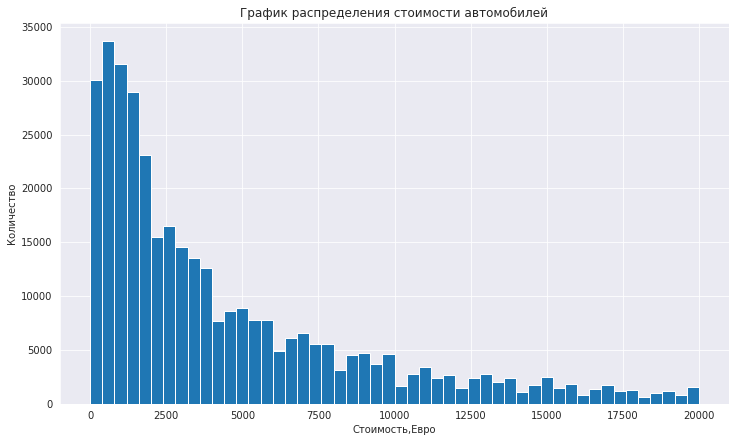

In [20]:
#оценим разброс цен на авто
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

Достаточно большое число машин со стоимостью близкой к нулю. Рассмотрим их ниже.

In [21]:
#оценим количество машин с ценой ниже 20 долл.
data.loc[data['Price'] < 20]['Price'].count()

12177

In [22]:
#удалим эти данные из выборки, так как, скорее всего, это ошибка

data = data.query('Price> 20')

#поверка данных

data.loc[data['Price'] < 20]['Price'].count()

0

In [23]:
#модель автомобиля играют первостепенную роли в определении его цены
print (' ')
print ('Model:', data['Model'].unique())
data.loc[data['Model'] == "other"]['Model'].count()

 
Model: ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra'
 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'corsa' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'coo

23580

В моделях нет явных дубликатов, но есть значение other оно неинфомративное, его следуте удалить (обновим выборку,
 уберем из нее значения, где вместо модели указано  other.

In [25]:
#введем переменную current_year, которая показывает текущий год
current_year = 2016

#добавим новый признак срок использования авто 

data['period_of_use'] = current_year - data['RegistrationYear']

data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,period_of_use
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown,23
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,5
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,12
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,15
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,8


In [26]:
#оценим разброс сроков использования автомобилей

a = data['period_of_use'].unique()
print(sorted(a))

[-7983, -7434, -6984, -6872, -6484, -6184, -5984, -5784, -5084, -4984, -3984, -3895, -3884, -3584, -3539, -3284, -2984, -2784, -2484, -2084, -1984, -1784, -1684, -1184, -984, -884, -784, -484, -274, -206, -184, -50, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 106, 216, 414, 416, 516, 616, 716, 761, 782, 905, 977, 1015, 1016]


Первый автомобиль изоборели в 1885 году, а советском союзе машины стали доступны в 50х годах, но думаю тут такие раритеты авnо не продают, поэтому удалим из датафрейма данные,где срок использования меньше 0 и более 75 лет.

In [27]:
data = data.query(' 0 <= period_of_use <75')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328290 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             328290 non-null  int64 
 1   VehicleType       328290 non-null  object
 2   RegistrationYear  328290 non-null  int64 
 3   Gearbox           328290 non-null  object
 4   Power             328290 non-null  int64 
 5   Model             328290 non-null  object
 6   Kilometer         328290 non-null  int64 
 7   FuelType          328290 non-null  object
 8   Brand             328290 non-null  object
 9   Repaired          328290 non-null  object
 10  period_of_use     328290 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 30.1+ MB


Было 354 369 стало 328 290, удалили 7,4 % данных, это данные, где указаны слишком низкая цена (менее 20 долл) и, где срок использования авто более 75 лет.

In [29]:
#посмотрим еще раз описание
data.describe()

,Price,RegistrationYear,Power,Kilometer,period_of_use
count,328290.000000,328290.000000,328290.000000,328290.000000,328290.000000
mean,4626.076088,2002.634223,112.107761,128306.573456,13.365777
std,4545.485247,6.750194,185.078930,37351.696250,6.750194
min,21.000000,1942.000000,0.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,71.000000,125000.000000,9.000000
50%,2950.000000,2003.000000,105.000000,150000.000000,13.000000
75%,6690.000000,2007.000000,143.000000,150000.000000,17.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,74.000000


Признаки


<AxesSubplot:>

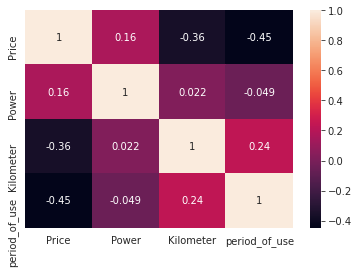

In [30]:
#удалим столбец RegistrationYear, так как он по смыслу дублирует  данные в колонке period_of_use
data = data.drop(columns=['RegistrationYear']) 
#тепловая карта корреляции  -проверим корреляцию данных 
print ('Признаки')
upp_mat = np.triu(data.corr())
sns.heatmap(data.corr(), annot = True)

По тепловой карте корреляции наблюдается зависимость цены от срока использвания авто от года регистрации, можность авто. Отрициательная зависимость есть между ценой  и пробегом. Данные логичны, между ними нет сильной прямой зависимости.

Перейдем к разделению данных на выборки и обучению моделей.

***Итоги предобработки данных***

Избавилась от:
 - признаков, которые никак не влияют на целевой признак: 'DateCreated','PostalCode', 'LastSeen', 'NumberOfPictures';
 
 - полных дубликатов;
 - был введен новый признак period_of_use и удален схожий с ним RegistrationYear;
 - избавились от выбросов в целевом признаке Price и признаках period_of_use

Заполнили и  удалили  пропуски:
 - пропущенные значения в VehicleType и FuelType заменилли на уже имеющиеся в списке варианты other;
 - удалили пропуски в колонках Gearbox, Model, так как эти данные напрямую и в первую очередь вдияют на цену, и пользователю авто их несложно узнать, имея машину; тип данных к графе Gearbox именили на bool;
 - пропуск в графе Repaired заменили на unknown;
 
 
В целом получили логичные данные:
цена прямо пропорционально от мощности и обратно пропорционально от пробега и периода использования



Было 354 369 стало 328 290, удалили 7,4 % данных, это данные, где указаны слишком низкая цена (менее 20 долл) и, где срок использования авто более 75 лет.

In [31]:
#проверим еще раз на наличие дубликатов
#удаление полных дубликатов и проверка
data = data.drop_duplicates().reset_index(drop=True) 
print(data.duplicated().sum())

0


In [32]:
#удаление полных дубликатов и проверка
data = data.drop_duplicates().reset_index(drop=True) 
print(data.duplicated().sum())

0


In [33]:
#сброс индексов после удаления аномалий в данных
data=data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286097 entries, 0 to 286096
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Price          286097 non-null  int64 
 1   VehicleType    286097 non-null  object
 2   Gearbox        286097 non-null  object
 3   Power          286097 non-null  int64 
 4   Model          286097 non-null  object
 5   Kilometer      286097 non-null  int64 
 6   FuelType       286097 non-null  object
 7   Brand          286097 non-null  object
 8   Repaired       286097 non-null  object
 9   period_of_use  286097 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


Было 354 369 стало 269  068, процент удаленных данных 

***Разделение данных на выборки - тренировочную и тестовую***

In [34]:
#разобьем данные на 3 выборки
df_train, df_train2 = train_test_split(data, test_size=0.6, random_state=12345)
df_valid, df_test = train_test_split(df_train2, test_size=0.2, random_state=12345)



#проверим разбивку на выборки

print(' ')
print('Размер тренировочной выборки', df_train.shape)
print('Размер валидационной выборки', df_valid.shape)
print('Размер тестовой выборки', df_test.shape)


 
Размер тренировочной выборки (114438, 10)
Размер валидационной выборки (137327, 10)
Размер тестовой выборки (34332, 10)


In [35]:
#выделяю признаки и целевой признак:

# < создаем переменные для признаков и целевого признака >
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']

features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price']

features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

print('Размер обучающей выборки:', df_train.shape)
print('Размер валидационной выборки:',df_valid.shape)
print('Размер тестовой выборки:',df_test.shape)
print('')

Размер обучающей выборки: (114438, 10)
Размер валидационной выборки: (137327, 10)
Размер тестовой выборки: (34332, 10)



***Кодирование качественных переменных техникой OHE***

In [36]:
# так как get_dummies() , который работает до разбиения данных на выборки, слелаем копию изначального датасета, 
#потом закодируем его и разобьем на выборки 

#выделим признаки и целевой признак
data1 = data.copy()
#features_ohe = data1.drop(['Price'], axis=1)
#target_ohe = data1['Price']


In [37]:
#кодируем прищнаки данных техникой OHE 
data1 = pd.get_dummies(data1, drop_first=True)

data1.head()

,Price,Power,Kilometer,period_of_use,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
0,480,0,150000,23,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,190,125000,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,163,125000,12,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,75,150000,15,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,69,90000,8,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#разобьем закодированные данные на выборки

data_train_ohe, data_train_ohe2 = train_test_split(data1, test_size=0.6, random_state=12345)
data_valid_ohe, data_test_ohe = train_test_split(data_train_ohe2, test_size=0.2, random_state=12345)

#проверим разбивку на выборки

print(' ')
print('Размер тренировочной выборки', data_train_ohe.shape)
print('Размер валидационной выборки', data_valid_ohe.shape)
print('Размер тестовой выборки', data_test_ohe.shape)


 
Размер тренировочной выборки (114438, 309)
Размер валидационной выборки (137327, 309)
Размер тестовой выборки (34332, 309)


In [39]:
data_train_ohe.head()

,Price,Power,Kilometer,period_of_use,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
241448,2000,143,150000,14,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173835,2000,194,150000,16,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
26445,5900,150,150000,13,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
243201,13150,105,30000,6,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
258438,1400,144,150000,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#разделим переменные для признаков и целевого признака >
features_train_ohe = data_train_ohe.drop(['Price'], axis=1)
target_train_ohe = data_train_ohe['Price']

features_valid_ohe = data_valid_ohe.drop(['Price'], axis=1)
target_valid_ohe = data_valid_ohe['Price']

features_test_ohe = data_test_ohe.drop(['Price'], axis=1)
target_test_ohe = data_test_ohe['Price']



In [41]:
print('Размер обучающей выборки:', features_train_ohe.shape)
print('Размер валидационной выборки:',features_valid_ohe.shape)
print('Размер тестовой выборки:',features_test_ohe.shape)
print('')
target_valid_ohe.head()

Размер обучающей выборки: (114438, 308)
Размер валидационной выборки: (137327, 308)
Размер тестовой выборки: (34332, 308)



223673      600
90554      1190
236796     7799
91129       300
39080     16499
Name: Price, dtype: int64

***Кодирование качественных переменных техникой OrdinalEncoding***

In [42]:
#копируем выборки
features_train_1 =features_train.copy()
features_valid_1=features_valid.copy()
features_test_1=features_test.copy()

#оставляет только категориальные переменные
features_train_2 =features_train_1.select_dtypes(include=['object']).copy()
features_valid_2=features_valid_1.select_dtypes(include=['object']).copy()
features_test_2=features_test_1.select_dtypes(include=['object']).copy()

#инициализируем Encoder
encoder = OrdinalEncoder(handle_unknown = 'ignore')

#обучаем его на тренировочных данных
encoder.fit(features_train_2)

#получаем закодированные качественные переменные 
features_train_oe= pd.DataFrame(encoder.transform(features_train_2),
                                columns=features_train_2.columns,
                                index=features_train_2.index)

features_valid_oe= pd.DataFrame(encoder.transform(features_valid_2),
                                columns=features_valid_2.columns,
                                index=features_valid_2.index)

features_test_oe= pd.DataFrame(encoder.transform(features_test_2),
                                columns=features_test_2.columns,
                                index=features_test_2.index)
#проверка
features_test_oe.head()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
8970,2.0,1.0,11.0,6.0,2.0,0.0
267922,2.0,1.0,157.0,6.0,10.0,2.0
32164,5.0,1.0,83.0,6.0,24.0,0.0
67561,7.0,1.0,154.0,2.0,10.0,1.0
7408,0.0,1.0,249.0,6.0,24.0,0.0


In [43]:
#удаляме из выборок незакодированные категориальные переменные и добавляем закодированные

features_train_1 = features_train_1.drop(columns=['VehicleType','Gearbox','Model', 'FuelType', 'Brand', 'Repaired'])
features_valid_1 = features_valid_1.drop(columns=['VehicleType','Gearbox','Model', 'FuelType', 'Brand', 'Repaired'])
features_test_1 = features_test_1.drop(columns=['VehicleType','Gearbox','Model', 'FuelType', 'Brand', 'Repaired'])
#
features_train_1.head()

,Power,Kilometer,period_of_use
241448,143,150000,14
173835,194,150000,16
26445,150,150000,13
243201,105,30000,6
258438,144,150000,13


In [44]:
#добавляем к оставшимся количестенным переменным закодированные качесвенные
features_train_oe = features_train_oe.join(features_train_1)
features_valid_oe = features_valid_oe.join(features_valid_1)
features_test_oe = features_test_oe.join(features_test_1)
features_train_oe.head()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,Power,Kilometer,period_of_use
241448,2.0,1.0,166.0,6.0,12.0,0.0,143,150000,14
173835,4.0,1.0,170.0,4.0,37.0,2.0,194,150000,16
26445,4.0,0.0,95.0,2.0,20.0,1.0,150,150000,13
243201,5.0,1.0,173.0,6.0,37.0,1.0,105,30000,6
258438,7.0,1.0,164.0,6.0,24.0,0.0,144,150000,13


In [45]:
#проверка
#обучющая выборка')
print(features_train_oe.head())
#валидационная выборка
print(features_train_oe.head())
#тестовая выборка
print(features_train_oe.head())

        VehicleType  Gearbox  Model  FuelType  Brand  Repaired  Power  \
241448          2.0      1.0  166.0       6.0   12.0       0.0    143   
173835          4.0      1.0  170.0       4.0   37.0       2.0    194   
26445           4.0      0.0   95.0       2.0   20.0       1.0    150   
243201          5.0      1.0  173.0       6.0   37.0       1.0    105   
258438          7.0      1.0  164.0       6.0   24.0       0.0    144   

        Kilometer  period_of_use  
241448     150000             14  
173835     150000             16  
26445      150000             13  
243201      30000              6  
258438     150000             13  
        VehicleType  Gearbox  Model  FuelType  Brand  Repaired  Power  \
241448          2.0      1.0  166.0       6.0   12.0       0.0    143   
173835          4.0      1.0  170.0       4.0   37.0       2.0    194   
26445           4.0      0.0   95.0       2.0   20.0       1.0    150   
243201          5.0      1.0  173.0       6.0   37.0       

***Вывод:***Кодирование качественных и количественных признаков прошло успешно прошло корректно.

Сделаем ниже еще одну копию признаков, где качественные признаким не закодированы, а с количественными проведено масштабировавание. Это набор признаком будем использовать для моднлей CatBoost  и LightGBM.

**Масштабирование данных с помощью StandardScaler**

In [46]:
#масштабирование данных для моделей линейной регрессии,, где признаки закодированы техникой OHE

numeric=['period_of_use','Power','Kilometer']
#создадим объект стандартизации и обучим его для моделей Линейной регречии и Дерева решений
scaler = StandardScaler()    
scaler.fit(features_train_ohe[numeric])
#сохраним преобразованные обучающую и тестовую  выборки в переменные
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric]) 


features_train_scaled = scaler.transform(features_train_ohe[numeric])
features_valid_scaled = scaler.transform(features_valid_ohe[numeric])
features_test_scaled = scaler.transform(features_test_ohe[numeric])

pd.options.mode.chained_assignment = None

In [48]:
features_train_scaled

array([[-1.90757127, -0.65428174, -3.33745551],
       [-1.86614706, -0.65254251, -3.33745551],
       [-1.92828338, -0.65404303, -3.33745551],
       ...,
       [-1.94899549, -0.65452046, -3.33745551],
       [-1.72116232, -0.65322456, -3.33745551],
       [-1.82472285, -0.6549979 , -3.33745551]])

In [51]:
features_valid_scaled

array([[-1.84543496, -0.65567995, -3.33745551],
       [-1.80401075, -0.65915841, -3.33745551],
       [-1.96970759, -0.65312226, -3.33745551],
       ...,
       [-2.0111318 , -0.65731687, -3.33745551],
       [-1.76258653, -0.65527072, -3.33745551],
       [-1.82472285, -0.65008713, -3.33747272]])

In [49]:
print('Проверка выполения стандартизации')
print(' ')
print('Обучающая выборка')
print(features_train_ohe.head())
print('Валидационная выборка')
print(features_valid_ohe.head())
print('Тестовая выборка')
print(features_test_ohe.head())

Проверка выполения стандартизации
 
Обучающая выборка
           Power  Kilometer  period_of_use  VehicleType_convertible  \
241448  0.179752   0.599138       0.093772                        0   
173835  0.477578   0.599138       0.381606                        0   
26445   0.220630   0.599138      -0.050145                        0   
243201 -0.042159  -2.550149      -1.057565                        0   
258438  0.185591   0.599138      -0.050145                        0   

        VehicleType_coupe  VehicleType_other  VehicleType_sedan  \
241448                  1                  0                  0   
173835                  0                  0                  1   
26445                   0                  0                  1   
243201                  0                  0                  0   
258438                  0                  0                  0   

        VehicleType_small  VehicleType_suv  VehicleType_wagon  ...  \
241448                  0                0    

In [48]:
#масштабирование данных для моделей линейной регрессии, дерева решений b LightGBM

numeric=['period_of_use','Power','Kilometer']
#создадим объект стандартизации и обучим его для моделей Линейной регречии и Дерева решений
scaler = StandardScaler()    
scaler.fit(features_train_oe[numeric])
#сохраним преобразованные обучающую и тестовую  выборки в переменные
features_train_oe[numeric] = scaler.transform(features_train_oe[numeric])
features_valid_oe[numeric] = scaler.transform(features_valid_oe[numeric])
features_test_oe[numeric] = scaler.transform(features_test_oe[numeric]) 


features_train_scaled = scaler.transform(features_train_oe[numeric])
features_valid_scaled = scaler.transform(features_valid_oe[numeric])
features_test_scaled = scaler.transform(features_test_oe[numeric])

pd.options.mode.chained_assignment = None


In [49]:
print('Проверка выполения стандартизации')
print(' ')
print('Обучающая выборка')
print(features_train_oe.head())
print('Валидационная выборка')
print(features_valid_oe.head())
print('Тестовая выборка')
print(features_test_oe.head())

Проверка выполения стандартизации
 
Обучающая выборка
        VehicleType  Gearbox  Model  FuelType  Brand  Repaired     Power  \
241448          2.0      1.0  166.0       6.0   12.0       0.0  0.179752   
173835          4.0      1.0  170.0       4.0   37.0       2.0  0.477578   
26445           4.0      0.0   95.0       2.0   20.0       1.0  0.220630   
243201          5.0      1.0  173.0       6.0   37.0       1.0 -0.042159   
258438          7.0      1.0  164.0       6.0   24.0       0.0  0.185591   

        Kilometer  period_of_use  
241448   0.599138       0.093772  
173835   0.599138       0.381606  
26445    0.599138      -0.050145  
243201  -2.550149      -1.057565  
258438   0.599138      -0.050145  
Валидационная выборка
        VehicleType  Gearbox  Model  FuelType  Brand  Repaired     Power  \
223673          2.0      0.0  227.0       6.0    2.0       2.0 -0.059678   
90554           4.0      1.0   11.0       6.0    2.0       1.0 -0.655331   
236796          7.0      0.0 

In [50]:
#масштабирование данных для моделей CatBoost 

#копируем выборки для моделей 
features_train_boosting = features_train.copy()
features_valid_boosting = features_valid.copy()
features_test_boosting = features_test.copy()

numeric=['period_of_use','Power','Kilometer']
#создадим объект стандартизации и обучим его для моделей Линейной регречии и Дерева решений
scaler = StandardScaler()    
scaler.fit(features_train[numeric])
#сохраним преобразованные обучающую и тестовую  выборки в переменные
features_train_boosting[numeric] = scaler.transform(features_train[numeric])
features_valid_boosting[numeric] = scaler.transform(features_valid[numeric])
features_test_boosting[numeric] = scaler.transform(features_test[numeric]) 


features_train_scaled_boosting = scaler.transform(features_train[numeric])
features_valid_scaled_boosting = scaler.transform(features_valid[numeric])
features_test_scaled_boosting = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None


print('Проверка выполения стандартизации')
print(' ')
print('Обучающая выборка')
print(features_train_boosting.head())
print('Валидационная выборка')
#print(features_valid_boosting.head())
print('Тестовая выборка')
#print(features_test_boosting.head())

Проверка выполения стандартизации
 
Обучающая выборка
       VehicleType Gearbox     Power     Model  Kilometer  FuelType  \
241448       coupe  manual  0.179752     other   0.599138    petrol   
173835       sedan  manual  0.477578    passat   0.599138       lpg   
26445        sedan    auto  0.220630  e_klasse   0.599138  gasoline   
243201       small  manual -0.042159      polo  -2.550149    petrol   
258438       wagon  manual  0.185591     omega   0.599138    petrol   

                Brand Repaired  period_of_use  
241448        hyundai       no       0.093772  
173835     volkswagen      yes       0.381606  
26445   mercedes_benz  unknown      -0.050145  
243201     volkswagen  unknown      -1.057565  
258438           opel       no      -0.050145  
Валидационная выборка
Тестовая выборка


In [51]:
#сбросим индексы, чтобы в дальнейшем было проще сопостовлять данные в target и prediction
features_train_oe = features_train_oe.reset_index(drop=True)
features_valid_oe = features_valid_oe.reset_index(drop=True)
features_test_oe = features_test_oe.reset_index(drop=True)

features_train_boosting = features_train_boosting.reset_index(drop=True)
features_valid_boosting = features_valid_boosting.reset_index(drop=True)
features_test_boosting = features_test_boosting.reset_index(drop=True)


target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
target_test = target_test .reset_index(drop=True)
print(features_train.columns)
print(features_test_oe.head())

Index(['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType',
       'Brand', 'Repaired', 'period_of_use'],
      dtype='object')
   VehicleType  Gearbox  Model  FuelType  Brand  Repaired     Power  \
0          2.0      1.0   11.0       6.0    2.0       0.0  0.179752   
1          2.0      1.0  157.0       6.0   10.0       2.0  1.149149   
2          5.0      1.0   83.0       6.0   24.0       0.0 -0.655331   
3          7.0      1.0  154.0       2.0   10.0       1.0  0.103835   
4          0.0      1.0  249.0       6.0   24.0       0.0  0.162232   

   Kilometer  period_of_use  
0  -0.056963      -0.050145  
1  -2.287709      -1.345399  
2   0.599138       0.093772  
3   0.599138       0.093772  
4  -2.287709      -1.489316  


***Вывод***
Данные прошли преобработку, выборки разделены на тренировочную и тестовую, данные закодированы и масштабированы. Теперь приступим к обучению моделей, выбору  лучшей, при этом оценивая качество предсказания и  скорость обучения.
При этом по условию задачи значение метрики RMSE должно быть меньше 2500.

## Обучение моделей

***Linear Regression***

In [52]:
%%time
start = time.time()

#подберем параметры модели LinearRegression с помощью цикла

result =2500
for i in range (1,20):
    lmodel = LinearRegression(normalize=True, n_jobs = i)
    lmodel.fit(features_train_scaled, target_train_ohe)
    prediction_lmodel = lmodel.predict(features_valid_scaled)
    mse_lr_model = mean_squared_error(target_valid_ohe, prediction_lmodel)
    rmse_lr_model = round((mse_lr_model) ** 0.5, 2)
    if rmse_lr_model < result:
        result = rmse_lr_model
        n_jobs = i #наибольшая доля правильных ответов
            
end = time.time()
training_time_lr = end-start
    

print("Время обучения LinearRegression: %s секунд" % training_time_lr)
print("Количество заданий для вычисления" , i)
print("Лучший RMSE для модели LinearRegression", rmse_lr_model)

Время обучения LinearRegression: 1.7330057621002197 секунд
Количество заданий для вычисления 19
Лучший RMSE для модели LinearRegression 3916.02
CPU times: user 560 ms, sys: 1.21 s, total: 1.77 s
Wall time: 1.74 s


In [53]:
#отдельно посчитиаем время обучения по подобранным параментрам

start = time.time()
lmodel = LinearRegression(normalize=True, n_jobs = 19)

lmodel.fit(features_train_ohe, target_train_ohe)

end = time.time()
training_time_lr = end-start

print("Время обучения LinearRegression: %s секунд" % training_time_lr)

Время обучения LinearRegression: 13.894651889801025 секунд


In [54]:
#посчитаем время предсказания

start = time.time()
prediction_lmodel = lmodel.predict(features_valid_ohe)

end = time.time()
prediction_time_lr = end-start
print("Время предсказания LinearRegression: %s секунд" % prediction_time_lr)

Время предсказания LinearRegression: 0.21145892143249512 секунд


In [55]:
features_train_oe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114438 entries, 0 to 114437
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   VehicleType    114438 non-null  float64
 1   Gearbox        114438 non-null  float64
 2   Model          114438 non-null  float64
 3   FuelType       114438 non-null  float64
 4   Brand          114438 non-null  float64
 5   Repaired       114438 non-null  float64
 6   Power          114438 non-null  float64
 7   Kilometer      114438 non-null  float64
 8   period_of_use  114438 non-null  float64
dtypes: float64(9)
memory usage: 7.9 MB


In [56]:
#RMSE моделей будем рассчитывать как корень из MAE

mse_lr_model = mean_squared_error(target_valid_ohe, prediction_lmodel)
rmse_lr_model = round((mse_lr_model) ** 0.5, 2)

print("RMSE для линейной модели на тестовой выборке:", rmse_lr_model)

RMSE для линейной модели на тестовой выборке: 198504700116786.6


***Регрессия DecisionTreeRegressor***

In [57]:
%%time
#инициализируем модедь DecisionTreeRegressor
dtr_model = DecisionTreeRegressor(random_state = 12345, criterion='mse')

#подберем параметры

grid_space={'max_depth':[3,5,10,100],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              #'min_samples_split':[1,2,3]
           }
#запускаем обучение
grid = GridSearchCV(dtr_model, param_grid = grid_space, cv=5)
model_grid = grid.fit(features_train_oe, target_train)

#model_predict = grid.predict(features_test_ohe, target_test)

#выводим результат
print('Лучшие параметры для модели: '+str(model_grid.best_params_))
print('Лучшая метрика модели: '+str(model_grid.best_score_))
#print('Лучшая модели, метрика на тестовой выборке : '+str(model_predict.best_estimator_))

Лучшие параметры для модели: {'max_depth': 100, 'max_features': 7, 'min_samples_leaf': 3}
Лучшая метрика модели: 0.7985301874759423
CPU times: user 20.5 s, sys: 247 ms, total: 20.8 s
Wall time: 20.8 s


In [58]:
#отдельно посчитиаем время обучения по подобранным параментрам

start = time.time()
dtr_model = DecisionTreeRegressor(random_state = 12345, criterion='mse', 
                              max_depth=100, 
                              max_features=7,
                              min_samples_leaf = 1) 

dtr_model.fit(features_train_oe, target_train)

end = time.time()
trainung_time_dtr = end-start

print("Время DecisionTreeRegressor: %s секунд" % trainung_time_dtr)

Время DecisionTreeRegressor: 0.34961891174316406 секунд


In [59]:
#посчитаем время предсказания

start = time.time()
preds_dtr_model = dtr_model.predict(features_valid_oe)

end = time.time()

prediction_time_dtr = end-start
print("Время предсказания DecisionTreeRegressor: %s секунд" % prediction_time_dtr)

Время предсказания DecisionTreeRegressor: 0.055304765701293945 секунд


In [60]:
#рассчитаем RMSE модели DecisionTreeRegressor

mse_dtr_model = mean_squared_error(target_valid, preds_dtr_model)
rmse_dtr_model = round((mse_dtr_model) ** 0.5, 2)
print("RMSE для DecisionTreeRegresso модели на тестовой выборке:", rmse_dtr_model)



RMSE для DecisionTreeRegresso модели на тестовой выборке: 2220.53


***Модель CatBoost***

In [61]:
%%time
#инициализируем модель CatBoost
cat_features = ['Brand', 'VehicleType', 'Gearbox', 'FuelType','Repaired','Model']
model_catboost = CatBoostRegressor(random_state = 12345, loss_function = 'RMSE', cat_features = cat_features)

#подберем параметры модели CatBoost с помощью GridSearch

grid_space={'iterations':[10, 20, 100],
            'learning_rate':[0.03,0.1],
              'depth':[3,6,10]
           }

#запускаем обучение
grid = GridSearchCV(model_catboost, param_grid = grid_space, cv=5)
model_grid = grid.fit(features_train_boosting, target_train)
#выводим результат
print('Best grid search hyperparameters are: '+str(model_grid.best_params_))

0:	learn: 4529.7872285	total: 78.1ms	remaining: 703ms
1:	learn: 4458.8045661	total: 109ms	remaining: 437ms
2:	learn: 4390.2755060	total: 130ms	remaining: 304ms
3:	learn: 4325.2918522	total: 159ms	remaining: 239ms
4:	learn: 4262.4712272	total: 179ms	remaining: 179ms
5:	learn: 4202.5965852	total: 199ms	remaining: 133ms
6:	learn: 4145.3701080	total: 219ms	remaining: 93.8ms
7:	learn: 4090.3462796	total: 239ms	remaining: 59.6ms
8:	learn: 4036.6278821	total: 258ms	remaining: 28.7ms
9:	learn: 3984.8024121	total: 279ms	remaining: 0us
0:	learn: 4529.2940405	total: 27.3ms	remaining: 246ms
1:	learn: 4458.0847292	total: 54.4ms	remaining: 217ms
2:	learn: 4389.5820724	total: 81.7ms	remaining: 191ms
3:	learn: 4324.2410883	total: 109ms	remaining: 164ms
4:	learn: 4261.2666429	total: 130ms	remaining: 130ms
5:	learn: 4200.7942986	total: 150ms	remaining: 100ms
6:	learn: 4143.7796627	total: 171ms	remaining: 73.1ms
7:	learn: 4088.2280798	total: 190ms	remaining: 47.5ms
8:	learn: 4034.7333947	total: 210ms	rem

In [62]:
#отдельно посчитиаем время обучения по подобранным параментрам

start_time = time.time()

model_catboost = CatBoostRegressor(iterations=100,
                                   learning_rate=0.1,
                                   depth=10,
                                   loss_function='RMSE',
                                   random_state=12345, cat_features = cat_features)

model_catboost.fit(features_train_boosting, target_train)

end_time = time.time()
training_time_catboost = end_time - start_time

# Время обучения модели CatBoostRegressor
print("Время обучения CatBoostRegressor: %s секунд" % training_time_catboost)


0:	learn: 4287.8195328	total: 109ms	remaining: 10.8s
1:	learn: 4007.1907636	total: 189ms	remaining: 9.26s
2:	learn: 3761.5432487	total: 265ms	remaining: 8.57s
3:	learn: 3539.1795727	total: 329ms	remaining: 7.9s
4:	learn: 3342.4115792	total: 392ms	remaining: 7.44s
5:	learn: 3174.4657706	total: 454ms	remaining: 7.11s
6:	learn: 3029.7853269	total: 514ms	remaining: 6.83s
7:	learn: 2898.9164842	total: 579ms	remaining: 6.66s
8:	learn: 2780.9963105	total: 651ms	remaining: 6.58s
9:	learn: 2680.5189067	total: 717ms	remaining: 6.45s
10:	learn: 2583.7758567	total: 782ms	remaining: 6.33s
11:	learn: 2496.4376519	total: 843ms	remaining: 6.18s
12:	learn: 2418.6470298	total: 903ms	remaining: 6.04s
13:	learn: 2355.6979273	total: 964ms	remaining: 5.92s
14:	learn: 2296.1495126	total: 1.02s	remaining: 5.8s
15:	learn: 2249.2490457	total: 1.09s	remaining: 5.72s
16:	learn: 2199.2936287	total: 1.15s	remaining: 5.62s
17:	learn: 2155.5497845	total: 1.21s	remaining: 5.52s
18:	learn: 2118.8000027	total: 1.28s	rem

In [63]:
#посчитаем время предсказания модели CatBoostRegressor

start_time = time.time()
pred_catboost = model_catboost.predict(features_valid_boosting)

end_time = time.time()
prediction_time_catboost = end_time - start_time
print("Время предсказания CatBoostRegressor: %s секунд" % prediction_time_catboost)

Время предсказания CatBoostRegressor: 0.22493720054626465 секунд


In [64]:
# Оценка качества модели CatBoostRegressor на тестовой выборке

mse_catboost = mean_squared_error(target_valid, pred_catboost)
rmse_catboost = round((mse_catboost) ** 0.5, 2)
print("RMSE CatBoostRegressor на тестовой выборке:'", rmse_catboost)

RMSE CatBoostRegressor на тестовой выборке:' 1726.55


***Модель LightGBM***

In [65]:
%%time
#инициализируем модель LightGBM

model_LGB = LGBMRegressor(random_state = 12345, metric='rmse')

#подберем параметры модели CatBoost с помощью GridSearch
grid_space={'n_estimators':[5,20],
            'learning_rate':[0.01, 0.1],
              'max_depth':[3, 7]
           }

#запускаем обучение
grid = GridSearchCV(model_LGB, param_grid = grid_space, cv=5)

model_grid = grid.fit(features_train_oe, target_train)


#выводим результат
print('Best grid search hyperparameters are: '+str(model_grid.best_params_))

Best grid search hyperparameters are: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 20}
CPU times: user 39 s, sys: 0 ns, total: 39 s
Wall time: 39.3 s


In [66]:
#отдельно посчитиаем время обучения по подобранным параментрам

start = time.time()

model_LGB = LGBMRegressor(random_state=123, objective='rmse', n_estimators=20, learning_rate=0.1, ax_depth = 7 )
model_LGB.fit(features_train_oe, target_train)

end_time = time.time()
training_time_LGBMR = end_time - start_time

# Время обучения модели CatBoostRegressor
print("Время обучения LGBMRegressor: %s секунд" % training_time_LGBMR)

Время обучения LGBMRegressor: 40.51188135147095 секунд


In [67]:
#посчитаем время предсказания модели LGBMRegressor(

start = time.time()
pred_LGB= model_LGB.predict(features_valid_oe)

end_time = time.time()
prediction_time_LGBMR = end_time - start_time
print("Время предсказания LGBMRegressor: %s секунд" % prediction_time_LGBMR)

Время предсказания LGBMRegressor: 40.808552503585815 секунд


In [68]:
# Оценка качества модели LGBMRegressorна тестовой выборке
mse_LGB = mean_squared_error(target_valid, pred_LGB)
rmse_LGB = round((mse_LGB) ** 0.5,2)
print("RMSE LGBMRegressor на тестовой выборке:'", rmse_LGB)

RMSE LGBMRegressor на тестовой выборке:' 2167.63


In [69]:
# Создание DataFrame с результатами
results = pd.DataFrame({'Model': ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LightGBM'],
                        'Training Time (sec)': [training_time_lr, trainung_time_dtr, training_time_catboost, 
                                                training_time_LGBMR],
                        'Prediction Time (sec)': [prediction_time_lr, prediction_time_dtr, prediction_time_catboost, 
                                                  prediction_time_LGBMR],
                        'RMSE (Validation)': [rmse_lr_model, rmse_dtr_model, rmse_catboost, rmse_LGB]})




# Вывод результатов
results

,Model,Training Time (sec),Prediction Time (sec),RMSE (Validation)
0,LinearRegression,13.894652,0.211459,1.985047e+14
1,DecisionTreeRegressor,0.349619,0.055305,2.220530e+03
2,CatBoostRegressor,7.666321,0.224937,1.726550e+03
3,LightGBM,40.511881,40.808553,2.167630e+03


***Вывод***
Мы обучили на тренировочной выборке  и сделали расчет времени времени обучения и предсказания, показателя RMSE на валидационной выборке. По показателям качества обучения  (данные по RMSE) со значительным опережением LiGHTGBM, но последней необходимо больше вреемени на обучение и предсказание. 

Поэтому ниже на тестовой выборке проведем финальное тестирование 2 моделей - CatBoostREgression и LiGHTGBM.

## Анализ моделей

In [70]:
%%time
#финальное тестирование модели CatBoostRegression на тестовой выборке, при этом оценим совокупное время на обучение
# и предсказание и величину показателя качества RMSE

start_time = time.time()

#model_catboost = CatBoostRegressor(iterations=100,
#                                   learning_rate=0.1,
#                                   depth=10,
#                                   loss_function='RMSE',
#                                  random_state=12345, cat_features = cat_features)

#model_catboost.fit(features_train_boosting, target_train)
pred_catboost = model_catboost.predict(features_test_boosting)


end_time = time.time()
general_time_catboost = end_time - start_time


# Время предсказания модели CatBoostRegressor
print("Время обучения CatBoostRegressor: %s секунд" % general_time_catboost)
# Оценка качества модели CatBoostRegressor на тестовой выборке

mse_catboost = mean_squared_error(target_test, pred_catboost)
rmse_catboost = round((mse_catboost) ** 0.5, 2)
print("RMSE CatBoostRegressor на тестовой выборке:'", rmse_catboost)

Время обучения CatBoostRegressor: 0.05088639259338379 секунд
RMSE CatBoostRegressor на тестовой выборке:' 1698.27
CPU times: user 52.9 ms, sys: 0 ns, total: 52.9 ms
Wall time: 52.2 ms


In [71]:
%%time
#финальное тестирование модели DTR на тестовой выборке, при этом оценим совокупное время на обучение
# и предсказание и величину показателя качества RMSE

pred_LGB= model_LGB.predict(features_valid_oe)


# Оценка качества модели LGBMRegressorна тестовой выборке
mse_LGB = mean_squared_error(target_valid, pred_LGB)
rmse_LGB = round((mse_LGB) ** 0.5,2)
print("RMSE LGBMRegressor на тестовой выборке:'", rmse_LGB)

RMSE LGBMRegressor на тестовой выборке:' 2167.63
CPU times: user 234 ms, sys: 0 ns, total: 234 ms
Wall time: 224 ms


***ВЫВОД:***

В проекте была поставлена задача - построить модель для определения стоимости автомобиля для приложения с лучшими показателями качества предсказания, скорости и времени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

Мы использовали технологию градиентного бустинга в моделях CatBoostRegressor и LightGBM, и сравнили её с базовыми моделями LinearRegression и DecisionTreeRegressor.

По итогам качества и скорости обучения на тестовых данных - лидирует модель CatBoostRegressor: RMSE = 1698.27, скорость обучения 9,33 сек., скорость предсказания 0,21 сек.

За ней со значительно худшими показателями качества скорости идет модель LightGBM: ее RMSE = 2167.63, скорость обучения 501,14 сек., скорость предсказания 509,76 сек.

Уверенно побеждает модель CatBoostRegressor.

Таким образом для компании "Не бит, не крашен" можем смело рекомендовать модель CatBoostRegressor, так как эта модель показываем наименьшее отклонение прогнозных цен от фактических. При этом у нее достаточно быстрая скорость обучения и предсказания.
 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей